# Úkol č. 1 - vizualizace dat a web scraping (do 11. října)

  * V rámci tohoto úkolu musíte stáhnout dat z webu (tzv. _web scraping_, velmi základní) a následně data zpracovat a vizualizovat.
  * Cílem bude stáhnout data ze serveru https://www.psp.cz/sqw/hlasovani.sqw?o=8 týkající hlasování současné poslanecké sněmovny, uložit tato data v tabulkovém formátu a pak vymyslet vizualizace a zobrazení dat, které umožní orientaci v těchto datech a zvýrazní zajímavé informace a zobrazit přehledně časový vývoj různých veličin.
 
> **Úkoly jsou zadány tak, aby Vám daly prostor pro invenci. Vymyslet _jak přesně_ budete úkol řešit, je důležitou součástí zadání a originalita či nápaditost bude také hodnocena!**

## Data

 * Měli byste stáhnout data ze všech hlasování současné poslanecké sněmovny (tj. od voleb v roce 2017) a to až na úroveň jednotlivých poslanců. 
 * Data by měla obsahovat i stručný popis toho, o jaké hlasování šlo.

## Pokyny k vypracování

**Základní body zadání**, za jejichž (poctivé) vypracování získáte **8 bodů**:
  * Strojově stáhněte data a uložte je do vhodného formátu, který se Vám bude dále dobře zpracovávat. 
  * **I když nemusíte mít sněmovnu rádi, snažte se nezahltit server a mezi požadavky na stránku mějte alespoň vteřinu mezeru.**
  * V druhé části Vašeho Jupyter notebooku pracujte se staženými daty v souborech, které jsou výsledkem Vašeho stahovacího skriptu (aby opravující nemusel spouštět stahování z webu).
  * S využitím vybraných nástrojů zpracujte data a vymyslete vizualizace a grafy, aby bylo vidět následující:
    * Odchody a přeběhnutí poslanců mezi jednotlivými stranami.
    * Jakou mají jednotliví poslanci docházku (účast na hlasování) a jak jsou na tom s docházkou strany jako celek.
    * Jak často spolu jednotlivé strany hlasují ve shodě a jak často hlasují odlišně.
    * Jak jsou poslanci jednotlivých stran jednotní v hlasování (jak často hlasují stejně, kdo jsou největší rebelové).

**Další body zadání** za případné další body (můžete si vybrat, maximum bodů za úkol je každopádně 12 bodů):
  * Ve vizualizacích a grafech nějak zachyťte časový vývoj (např. jak se mění docházka, shoda mezi stranami atp.).
  * Najděte jednotlivé poslance, kteří se nejvíce shodují při svém hlasování či kteří mají co nejpodobnější účast na hlasování.
  * Zkuste rozlišit v datech důležitá hlasování a zpracujte vizualizace (také) pro ně.
  * Zkuste najít hlasování, kde poslanci hlasovali nejvíce jinak, než obvykle.
  
## Tipy a triky
  * Balíčky iportujte na začátku notebooku (příp. na začátku scrapovací a pak na začátku vizualizační části).
  * Využívejte markdown buňky (jako je ta, ve které je tento text) a naspisy, abyste usnadnily orientaci opravující(mu).
  * Pečlivě si vybírejte grafy a vizualizace, aby co nejlépe vyjádřily to, co vyjádřit chcete. Doporučuji projít si pro inspiraci alespoň galerie balíčků `matplotlib` a `seaborn`.

## Poznámky k odevzdání

  * Řiďte se pokyny ze stránky https://courses.fit.cvut.cz/BI-VZD/homeworks/index.html.
  * Odevzdejte Jupyter Notebook (příp. doplněn skripty), ale i soubor(y) se staženými daty (ať opravující nemusí stahovat data).
  * Opravující Vám může umožnit úkol dodělat či opravit a získat tak další body. První verze je ale důležitá a bude-li odbytá, budete za to penalizováni.

## Crawler 

In [5]:
from bs4 import BeautifulSoup
from urllib.parse import urlencode
import requests
from time import sleep
import warnings
warnings.filterwarnings('ignore')
from unidecode import unidecode

In [ ]:
ps_url = 'https://www.psp.cz/sqw/'

### Udelejme tabulku hlasovani 
Prozkoumame url jednitlivych schuzi a hned vidime ze url ma v sobe parametr s, ktery rika o jakou schuzi se jedna
https://www.psp.cz/sqw/hl.sqw?o=8&s=60
Treba tento url odkazuje na stranku hlasovani 60. schuze 

Prozkoumejme url s tabulkami hlasovani jednotlivych shuzi. Tabulky s vysledky rozmisteny na nekolika strankach, jejichz pocet dopredu nezname. Napriklad nasledujici url odkazuje na 1. stranku s vysledky hlasovani 1.svhuzi.
https://www.psp.cz/sqw/phlasa.sqw?o=8&s=1&pg=1
Pokud schuze ma jenom jednu stranku s vysledky a my treba zadame nasledujici url
https://www.psp.cz/sqw/phlasa.sqw?o=8&s=1&pg=2
tak na strance se nezobazi tabulka. Zkusime postupne prochazet stranky dokud zadna tabulka se nezobrazi.

In [ ]:
df_sitting= None
for n_meeting in range(1, 61):  # loop trough all meetings
    n_page = 1
    while True:  # loop trough pages with voting results 
        params = {
            'o': 8,
            's': n_meeting,
            'pg': n_page
        }
        url = ps_url + 'phlasa.sqw?' + urlencode(params)
        try:  # to find table on the page
            tmp_df = pd.read_html(url)[0]
            if df_sitting is None: # df is empty yet
                df_sitting = tmp_df
            # 3 merge dfs
            df_sitting = pd.concat([df_sitting, tmp_df], ignore_index=True)
            print(f'>>{n_meeting}/{n_page}: table found')
            sleep(1)
            n_page += 1
        except ValueError: # No table found 
            break
            
df_sitting = df.rename(columns={
    'Schùze': 'Sitting',
    'È. hl.': 'N_vote',
    'Bod': 'Point',
    'Název': 'Name',
    'Datum': 'Date',
    'Výsledek': 'Result'
})

decode_dic = {
    'Poijato (zmateene)': 'Prijato (zmatecne)',
    'Poijato': 'Prijato',
    'Zamitnuto': 'Zamitnuto',
    'Zamitnuto (zmateene)': 'Zamitnuto (zmatecne)',
    'Zamitnuto (poijata namitka)': 'Zamitnuto (prijata namitka)',
    'Poijato (poijata namitka)':'Prijato (prijata namitka)'
}
df_sitting['Result'] = df_sitting['Result'].apply(lambda x: decode_dic[unidecode(x)])
df_sitting.to_csv('./sitting_votings.csv', index=False)


### Udelejme tabulku s hlasy jednotlivych poslancu 
Budeme muset prochazet tabulky jednotlivych hlasovani a pak parsovat stranku s hlasy jednotlivych poslancu

In [ ]:
def get_vote_res(vote):
    vote_dict = {
        'flag yes': 'yes',
        'flag no': 'no',
        'flag not-logged-in': 'not_registered',
        'flag excused': 'excused',
        'flag refrained': 'refrained'
    }
    return vote_dict[' '.join(vote.span['class'])]

def get_voters_name(vote):
    return unidecode(vote.a.text)

In [ ]:
votes = []
for n_meeting in range(1, 61):  # loop trough all meetings and get links to results 
    n_page = 1
    votings = dict()  #  voting_number: link to results
    while True:  # loop trough pages with voting results 
        params = {
            'o': 8,
            's': n_meeting,
            'pg': n_page
        }
        url = ps_url + 'phlasa.sqw?' + urlencode(params)
        response = requests.get(url)
        sleep(1)
        soup = BeautifulSoup(response.text, 'html.parser', from_encoding="iso-8859-1")
        table = soup.find('table')
        if table is None:  # table not found
            break
        for row in table.find_all('tr')[1:]:  # loop trough table rows
            col = row.find_all('td') 
            voting_number = col[1].text
            voting_link = col[1].a.get('href')
            votings[voting_number] = voting_link
        
        
        n_page += 1  
    
    #  Now scrape voting results in given sittings
    for voting_number, link in votings.items():
        url = ps_url + link
        response = requests.get(url)
        sleep(1)
        soup = BeautifulSoup(response.text, 'html.parser')
        parties_raw = soup.find_all('h2', {'class': 'section-title center'})[1: -1]
        parties = [unidecode(h2.span.text.split('(')[0].strip()) \
                   for h2 in parties_raw]
        results = soup.find_all('ul', {'class': 'results'})
        for party, party_res in zip(parties, results):
            print(f'>>s.{n_meeting}v.{voting_number}: {party}')
            for res in party_res:
                vote = get_vote_res(res)
                name = get_voters_name(res)
                votes.append([n_meeting, int(voting_number), name, party, vote])

df_votes = pd.DataFrame(votes, columns=['Sitting', 'Voting', 'Name', 'Party', "Vote"])
df_votes.to_csv('votes.csv', index=False)

### Vizualizace

In [1]:
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np 
import pandas as pd

In [2]:
votes_df = pd.read_csv('./votes.csv')
sittings_df = pd.read_csv('./sitting_votings.csv')

In [3]:
display(sittings_df.head())
votes_df.head()

Sitting  N_vote  Point                                             Name  \
0        1       1    3.0  Inf. o ustavení volební komise PS a volbì èlenù   
1        1       2    3.0  Inf. o ustavení volební komise PS a volbì èlenù   
2        1       3    NaN                           Procedurální hlasování   
3        1       4    4.0                   Náv.na stanovení poètu èl. MIV   
4        1       5    4.0                   Náv.na stanovení poètu èl. MIV   

                 Date              Result  
0  20. 11. 2017 13:53  Prijato (zmatecne)  
1  20. 11. 2017 13:53             Prijato  
2  20. 11. 2017 14:47           Zamitnuto  
3  20. 11. 2017 15:39           Zamitnuto  
4  20. 11. 2017 15:39             Prijato

Sitting  Voting                 Name Party Vote
0        1       1        Vera Adamkova   ANO  yes
1        1       1         Andrej Babis   ANO  yes
2        1       1      Andrea Babisova   ANO  yes
3        1       1  Margita Balastikova   ANO  yes
4        1       1         Josef Belica   ANO  yes

#### 1) Odchody a přeběhnutí poslanců mezi jednotlivými stranami.

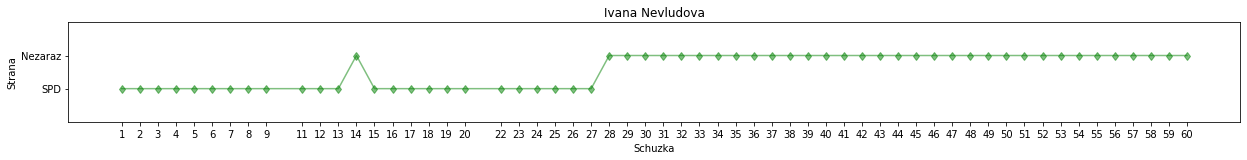

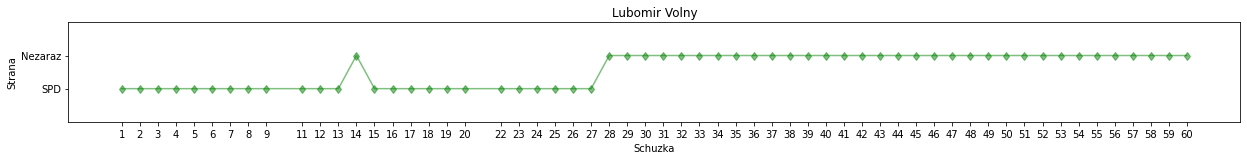

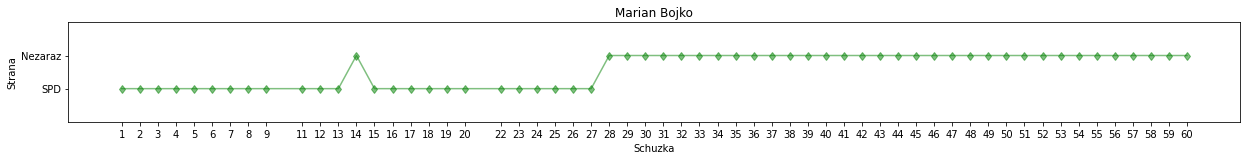

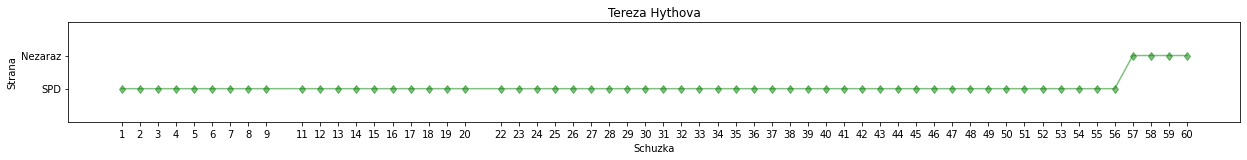

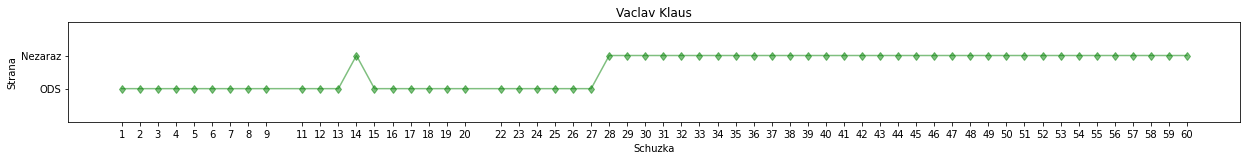

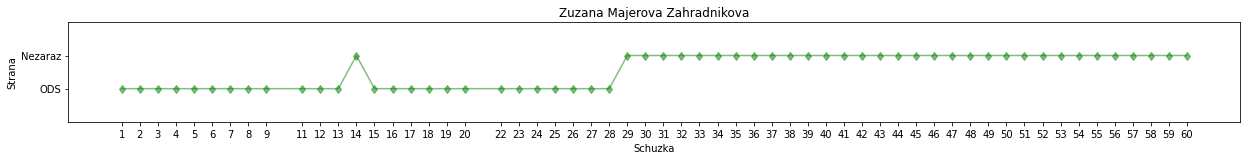

In [4]:
# axis
y_parties = votes_df.Party.unique()
x_sittings = votes_df.Sitting.unique()
name_parties = dict()

df_names_parties = votes_df.drop(columns=['Voting', 'Vote'])
for name, df in df_names_parties.groupby(by='Name'):
    if df.Party.nunique() >= 2:
        df = df.drop_duplicates('Sitting')
#         name_parties[name] = list(map(lambda x: np.where(y_parties == x)[0][0], df.Party.values))
        name_parties[name] = df.Party.values
        
        
i = 1

for name, vec in name_parties.items():
    plt.figure(figsize=(21, 15))
    plt.tight_layout()
    plt.subplot(7, 1, i)
    plt.xticks(x_sittings)
    plt.plot(x_sittings, vec, 'dg-' , alpha=0.5)
    plt.ylim(-1, len(np.unique(vec)))
    plt.xlabel('Schuzka')
    plt.ylabel('Strana')
    plt.title(name)
    plt.show()
    i += 1


Zajimave na tom grafu je to, ze hodne poslancu hlasovali jako nezarazeni behem 14. schuzky a po 27.

#### 2) Jakou mají jednotliví poslanci docházku (účast na hlasování) a jak jsou na tom s docházkou strany jako celek.
Zacneme tim, ze spocitame dohazku napric strany vsech hlasovani

In [6]:
attendancy_df = votes_df.copy()
attendancy_df['Attended'] = attendancy_df.Vote.apply(lambda x: 1 if x in ['yes', 'no', 'refrained'] else 0 )
attendancy_df = attendancy_df.drop(columns='Vote')
attendancy_df

Sitting  Voting                          Name    Party  Attended
0              1       1                 Vera Adamkova      ANO         1
1              1       1                  Andrej Babis      ANO         1
2              1       1               Andrea Babisova      ANO         1
3              1       1           Margita Balastikova      ANO         1
4              1       1                  Josef Belica      ANO         1
...          ...     ...                           ...      ...       ...
1386795       60      26                Tereza Hythova  Nezaraz         0
1386796       60      26                  Vaclav Klaus  Nezaraz         0
1386797       60      26  Zuzana Majerova Zahradnikova  Nezaraz         0
1386798       60      26               Ivana Nevludova  Nezaraz         1
1386799       60      26                 Lubomir Volny  Nezaraz         1

[1386800 rows x 5 columns]

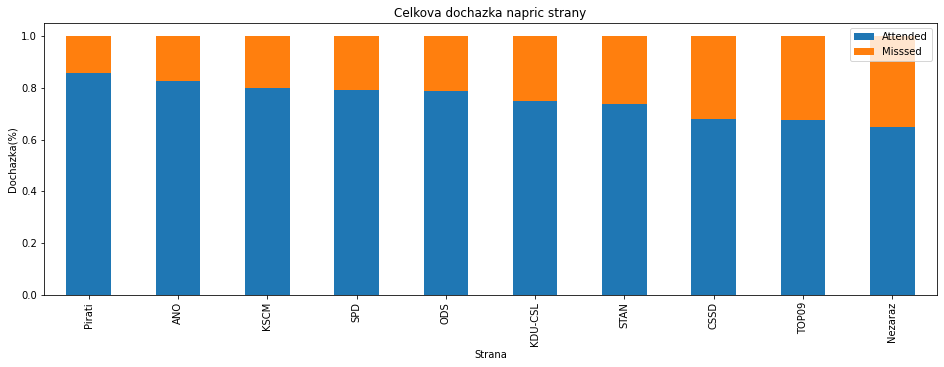

In [7]:
def get_att_sum(values):
    if len(values) == 2:
        return values
    else:
        if values.index == 1:
            return values[1], 0
        else:
            return 0, values[0]

sum_attendancy = []
for name, df in attendancy_df.groupby('Party'):
    att_vals = df.Attended.value_counts()
    y, n = get_att_sum(att_vals)
    sum_attendancy.append([name, y/(y + n), n/(y + n)])
    
sum_attendancy_df = pd.DataFrame(sum_attendancy, columns=['Party', 'Attended', 'Misssed']).sort_values('Attended', ascending=False)


sum_attendancy_df.plot(kind='bar', stacked=True, figsize=(16, 5))
names = sum_attendancy_df.Party.values
plt.xticks(range(len(names)), names);
plt.xlabel('Strana');
plt.ylabel('Dochazka(%)');
plt.title('Celkova dochazka napric strany');

Z toho grafu vidime, ze nejlepsi ucast na hlasovanich maji Pirati.

Zkusime vysetrit casovy vyvoj dochazky jednotlivych stran 

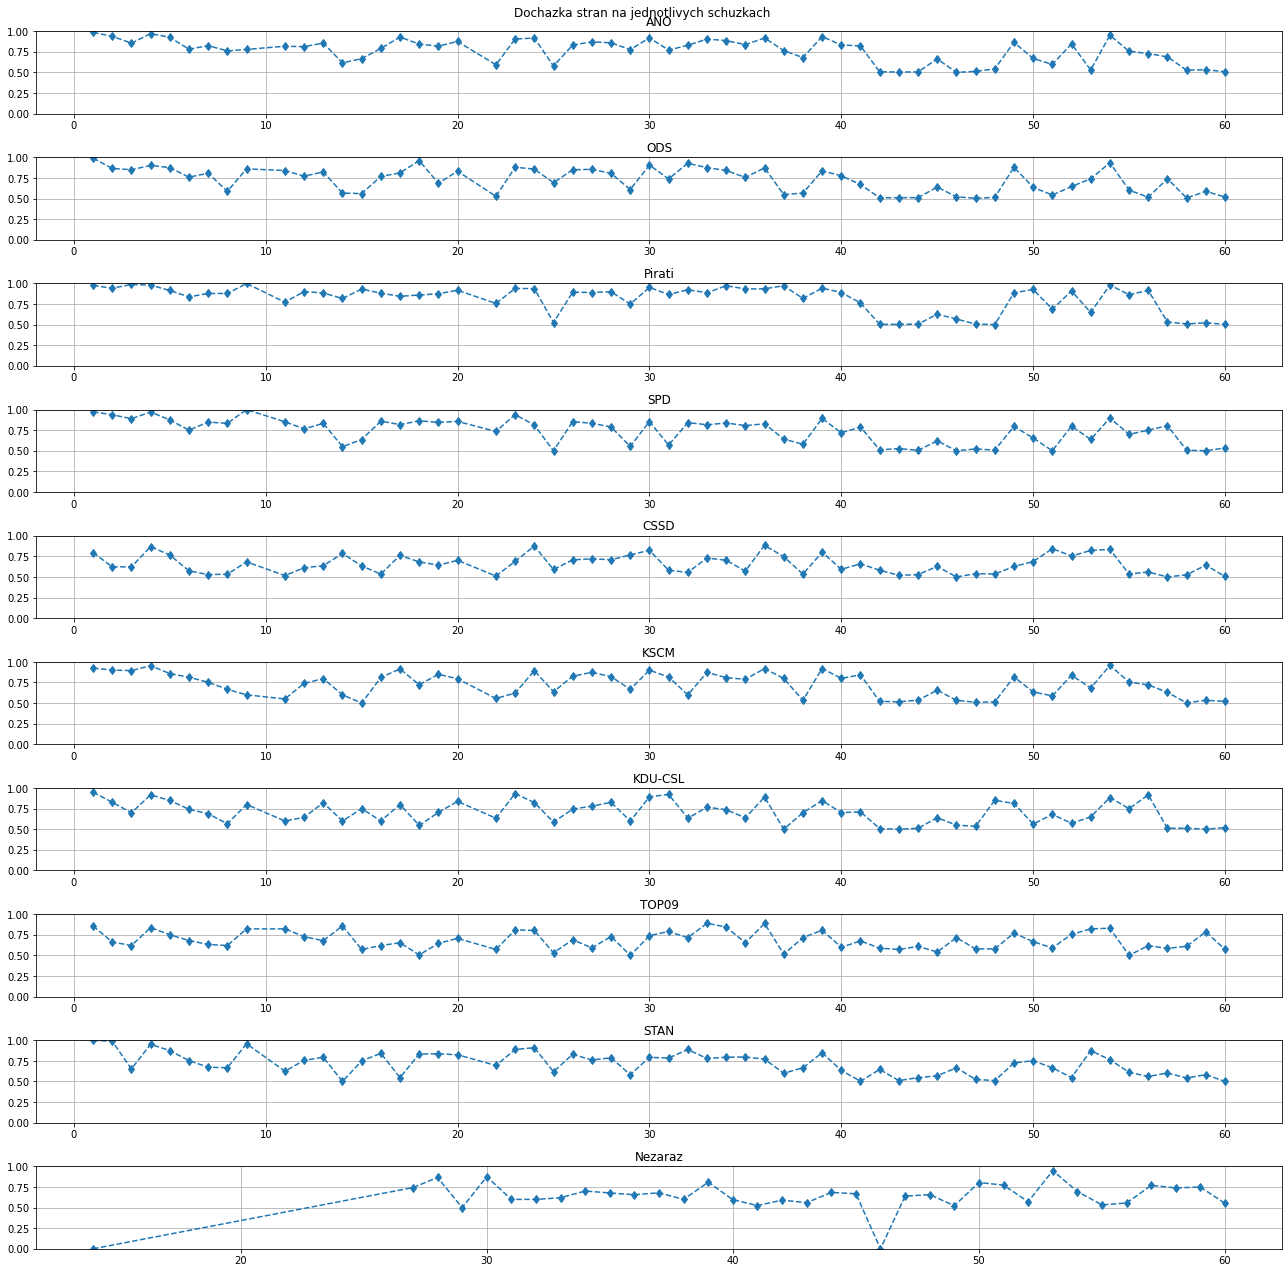

In [8]:
attendancy_dic = dict((party, []) for party in attendancy_df.Party.unique())
sittings = attendancy_df.Sitting.unique()
for key, df in attendancy_df.groupby(['Sitting', 'Party']):
    sitting, party = key
    att_vals = df.Attended.value_counts()
    y, n = get_att_sum(att_vals)
    attendancy_dic[party].append(y / (y + n))


    
fig = plt.figure(figsize=(18, 18))
for i, item in enumerate(attendancy_dic.items()):
    party, vec = item
    if party == 'Nezaraz':  # nezavisle poslanci zucastnili jen 35 schuzek
        break
    ax = plt.subplot(10, 1, i + 1)
    ax.plot(sittings, vec,'d--')
    ax.set_title(party)
    ax.set_ylim(0, 1)
    ax.grid()

ax = plt.subplot(10, 1, 10)
sittings_independent = attendancy_df[attendancy_df['Party'] == 'Nezaraz'].Sitting.unique()
ax.plot(sittings_independent, attendancy_dic['Nezaraz'], 'd--')
ax.set_title('Nezaraz')
ax.set_ylim(0,1)
ax.grid()

fig.suptitle('Dochazka stran na jednotlivych schuzkach ')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


Zajimave na tom gravu je to ze ve mnoha stranach byla velmi nizka dochazka mezi 40. a 50. schuzkou (koronakrize)

Ted zobrazime dochazku jednotlivych poslancu 

<AxesSubplot:>

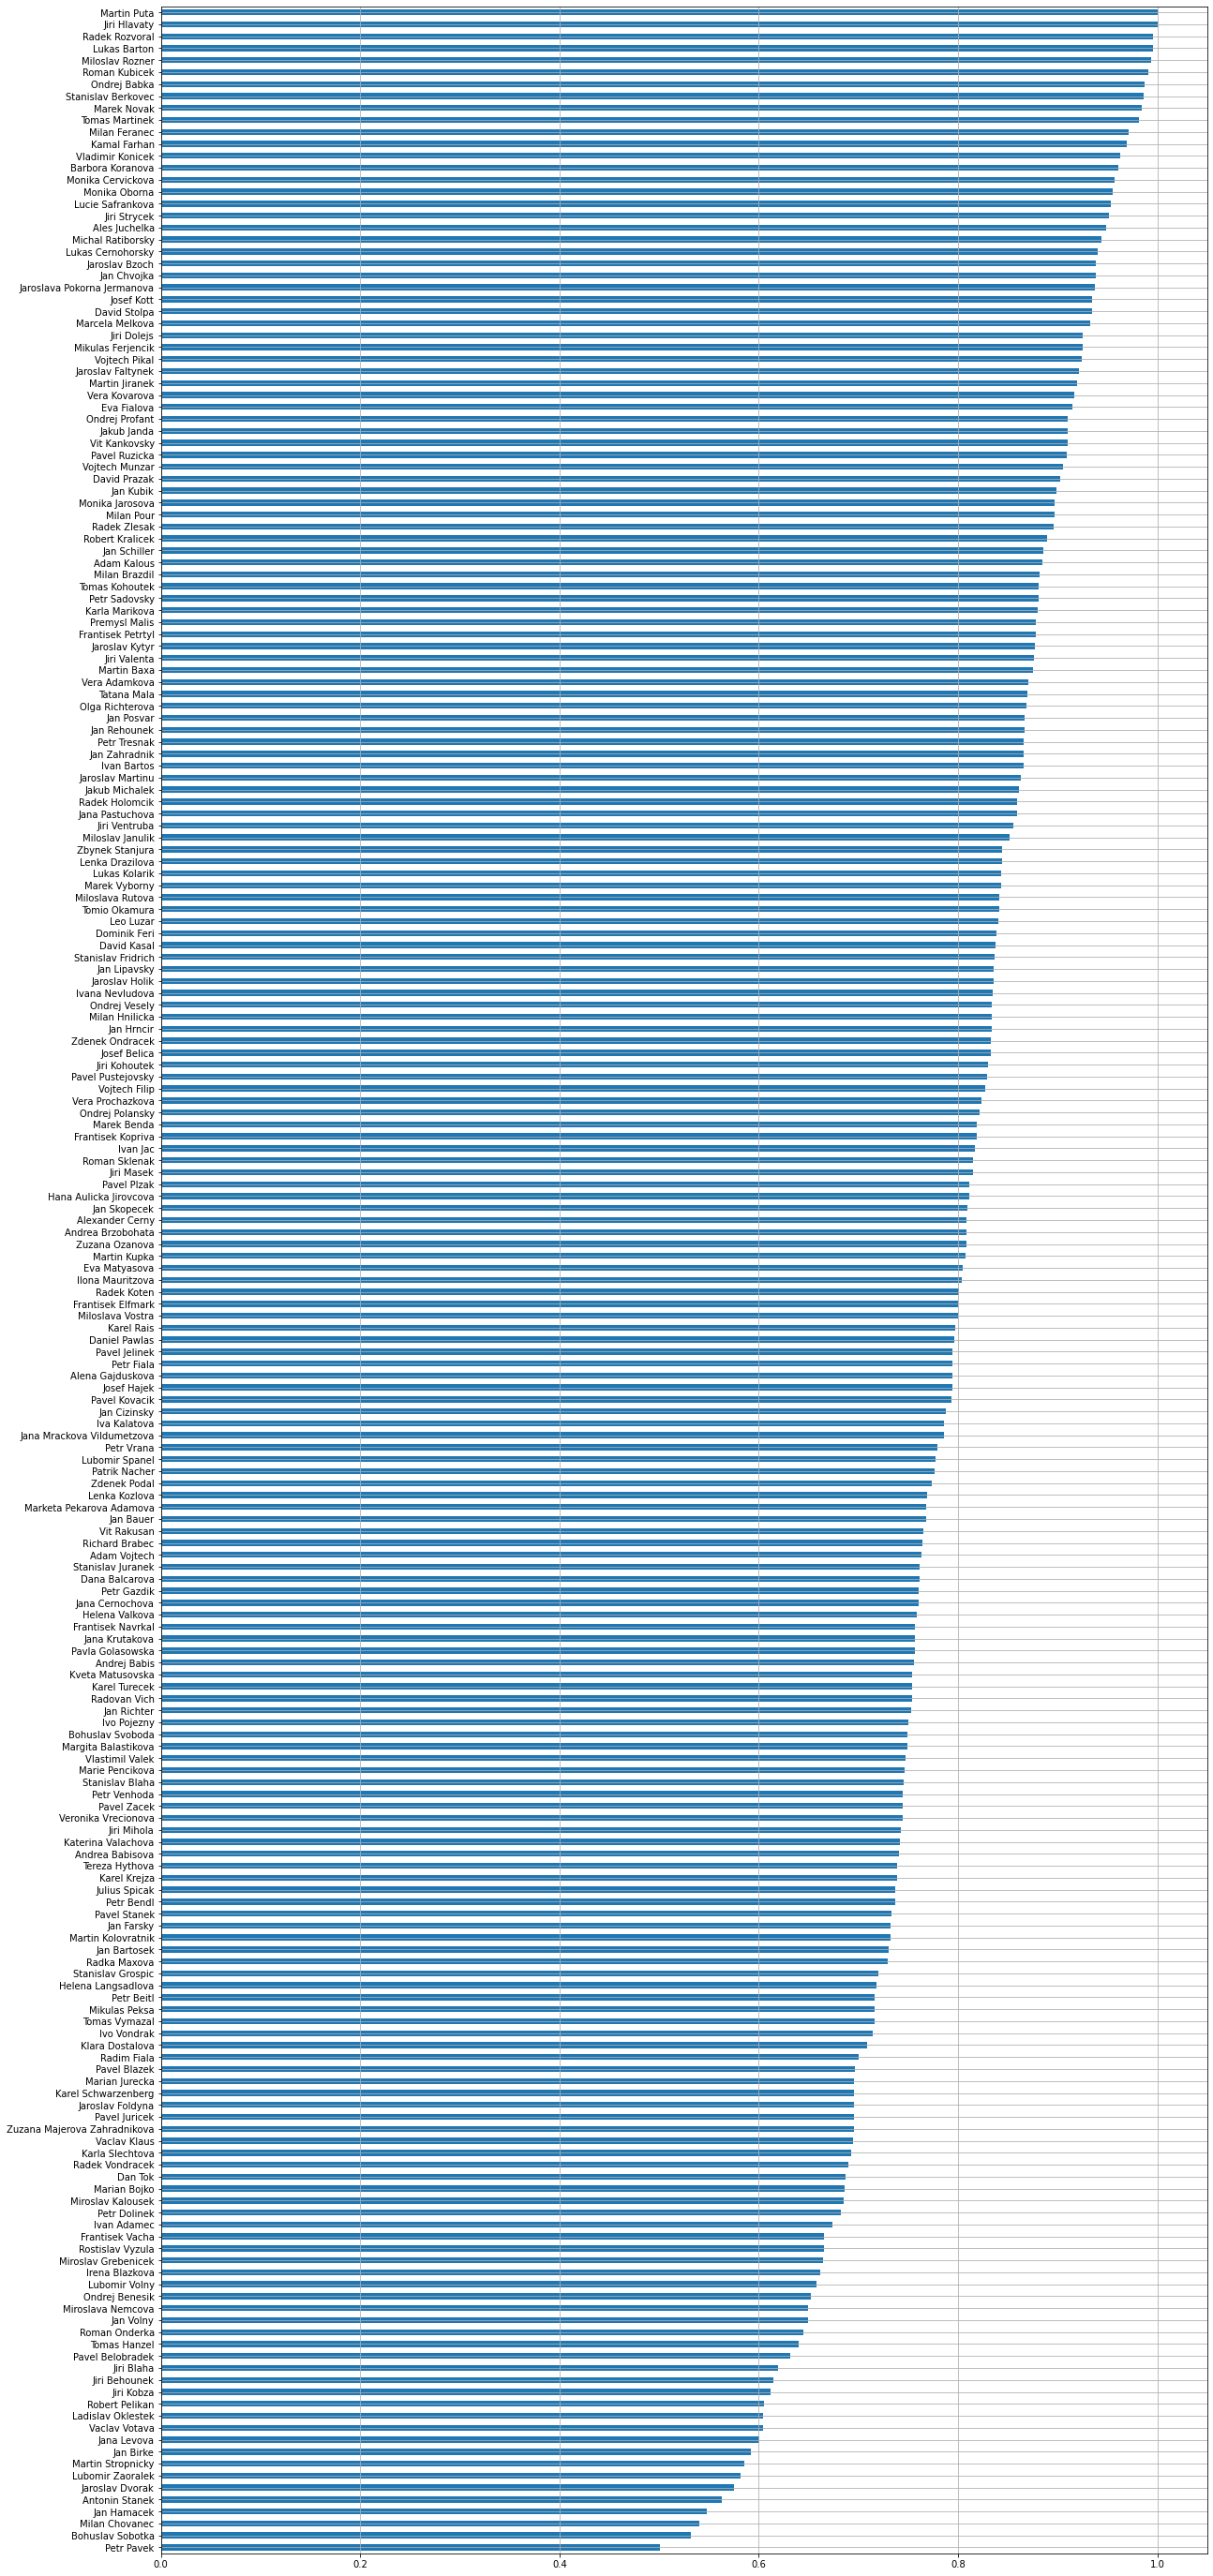

In [9]:
deputy_att = dict()

for name, df in attendancy_df.groupby('Name'):
    att_vals = df.Attended.value_counts()
    y, n = get_att_sum(att_vals)
    deputy_att[name] = y / (y + n)
    
deputy_att = {k: v for k, v in sorted(deputy_att.items(), key=lambda x: x[1])}

temp_df = pd.DataFrame.from_dict(data=deputy_att, orient='index', columns=['Attendancy'])
temp_df.plot.barh(figsize=(20, 50), grid=True, legend=False)

Martin Puta a Jiri hlavaty se dorazili na vsechna hlasovani.

In [10]:
display(temp_df.describe())
temp_df.plot.box()
plt.ylabel('Dochazka');

Attendancy
count  213.000000
mean     0.798254
std      0.108447
min      0.500867
25%      0.733199
50%      0.804009
75%      0.876695
max      1.000000

Tady vidime, ze vetsina poslancu dorazila na vic nez 80% hlasovani. Nejhorsi dochzku ma Petr Pavek, ktery se zucastnil jen 50% hlasovani

#### 3) Jak často spolu jednotlivé strany hlasují ve shodě a jak často hlasují odlišně.

Zaprve zakodujeme hlasy pomoci one-hot encodingu

In [11]:
votes = pd.concat([votes_df.drop(columns='Vote'), pd.get_dummies(votes_df.Vote)], axis = 1)
votes

Sitting  Voting                          Name    Party  excused  no  \
0              1       1                 Vera Adamkova      ANO        0   0   
1              1       1                  Andrej Babis      ANO        0   0   
2              1       1               Andrea Babisova      ANO        0   0   
3              1       1           Margita Balastikova      ANO        0   0   
4              1       1                  Josef Belica      ANO        0   0   
...          ...     ...                           ...      ...      ...  ..   
1386795       60      26                Tereza Hythova  Nezaraz        1   0   
1386796       60      26                  Vaclav Klaus  Nezaraz        1   0   
1386797       60      26  Zuzana Majerova Zahradnikova  Nezaraz        1   0   
1386798       60      26               Ivana Nevludova  Nezaraz        0   0   
1386799       60      26                 Lubomir Volny  Nezaraz        0   1   

         not_registered  refrained  yes  
0                     0          0    1  
1                     0          0    1  
2                     0          0    1  
3                     0          0    1  
4                     0          0    1  
...                 ...        ...  ...  
1386795               0          0    0  
1386796               0          0    0  
1386797               0          0    0  
1386798               0          1    0  
1386799               0          0    0  

[1386800 rows x 9 columns]

Priznaky excused a not-registered nas zaijmat nebudou

In [12]:
votes_columns = ['no', 'refrained', 'yes']
votes.drop(columns=['excused', 'not_registered'], inplace=True)

In [13]:
votes 

Sitting  Voting                          Name    Party  no  \
0              1       1                 Vera Adamkova      ANO   0   
1              1       1                  Andrej Babis      ANO   0   
2              1       1               Andrea Babisova      ANO   0   
3              1       1           Margita Balastikova      ANO   0   
4              1       1                  Josef Belica      ANO   0   
...          ...     ...                           ...      ...  ..   
1386795       60      26                Tereza Hythova  Nezaraz   0   
1386796       60      26                  Vaclav Klaus  Nezaraz   0   
1386797       60      26  Zuzana Majerova Zahradnikova  Nezaraz   0   
1386798       60      26               Ivana Nevludova  Nezaraz   0   
1386799       60      26                 Lubomir Volny  Nezaraz   1   

         refrained  yes  
0                0    1  
1                0    1  
2                0    1  
3                0    1  
4                0    1  
...            ...  ...  
1386795          0    0  
1386796          0    0  
1386797          0    0  
1386798          1    0  
1386799          0    0  

[1386800 rows x 7 columns]

In [14]:
votes_sum = votes.drop(columns=['Voting', 'Sitting']).groupby(['Party']).sum()
votes_sum

no  refrained       yes
Party                                 
ANO      151810.0    87757.0  207237.0
CSSD      18273.0    20185.0   30929.0
KDU-CSL    4033.0     7648.0   40397.0
KSCM      19705.0    25614.0   37866.0
Nezaraz     932.0     4742.0    9271.0
ODS       12667.0    20285.0   96584.0
Pirati    12307.0    19243.0   99426.0
SPD        9601.0    22146.0   78972.0
STAN       1997.0     5667.0   23060.0
TOP09      2538.0     5667.0   24581.0

<AxesSubplot:xlabel='Party'>

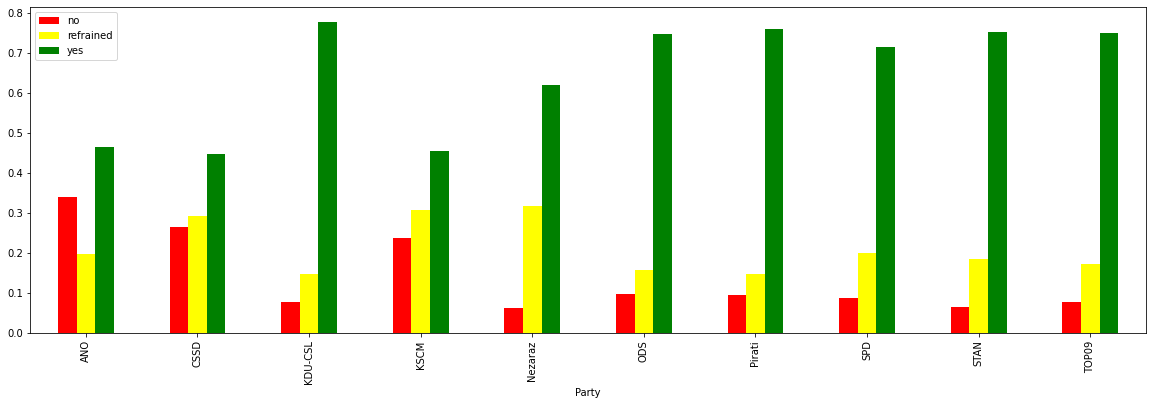

In [48]:
votes_normalised = votes_sum.div(votes_sum.sum(axis=1), axis=0).dropna()  # normalisation
votes_normalised.plot.bar(figsize=(20, 6), color=['red', 'yellow', 'green'])

Tady vidime zajimavou statistiku. Vetsina stran (KDU-CSL, ODS, Pirati, SPD, STAN a TOP09) v drtive vetsine hlasovani hlasujou za, pomer hlasu proti je velmi maly. Strany ANO, CSSD a KSCM naopak maji rozdeleni hlasu vic rovnomerne (treba ANO ve vice nez 30% pripadu hlasuje proti).  

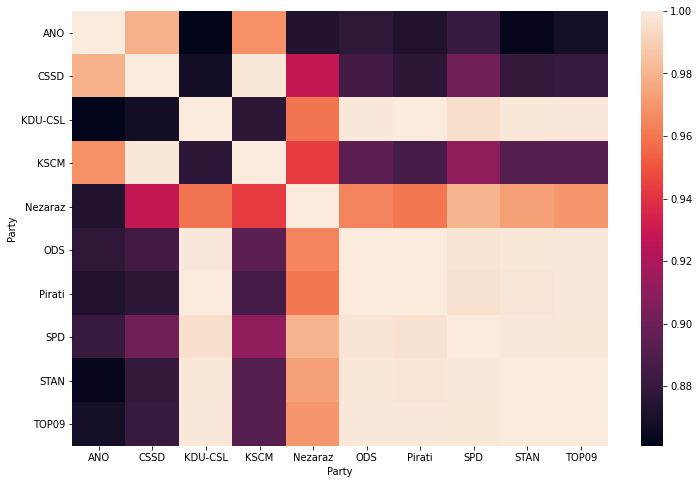

In [47]:
from sklearn.metrics.pairwise import cosine_similarity
temp_df = pd.DataFrame(cosine_similarity(votes_normalised), index=votes_normalised.index, columns=votes_normalised.index)
# temp_df = votes_normalised.T.corr()
# display(temp_df)
plt.figure(figsize=(12,8))
sns.heatmap(data=temp_df);

Tady vidime schodu hlasu jednotlivych stran (spocitanou pomoci kosinove podobnosti). Vidime, ze treba ANO hlasuje docela odlisne od ODS, Piratu, SPD, STANu a TOP09, kteri maji docela schodne statistiky hlasu.

#### 4) Jak jsou poslanci jednotlivých stran jednotní v hlasování (jak často hlasují stejně, kdo jsou největší rebelové)
Ted zkusime jit stejnym smerem jako v predchozim bode. Napocitejme statistiku hlasovani jednotlivych poslancu prislusnych stranam a mezi poslanci jedne strany spocitejme kosinovou podobnost jejich hlasu a na heatmape hned uvidime nejvetsi rebelove v strane. Toto udelame pro kazdou stranu

Nejvetsi rebelove strany ANO jsou: Irena Blazkova, Jaroslava Pokorna Jermanova, Pavel Stanek


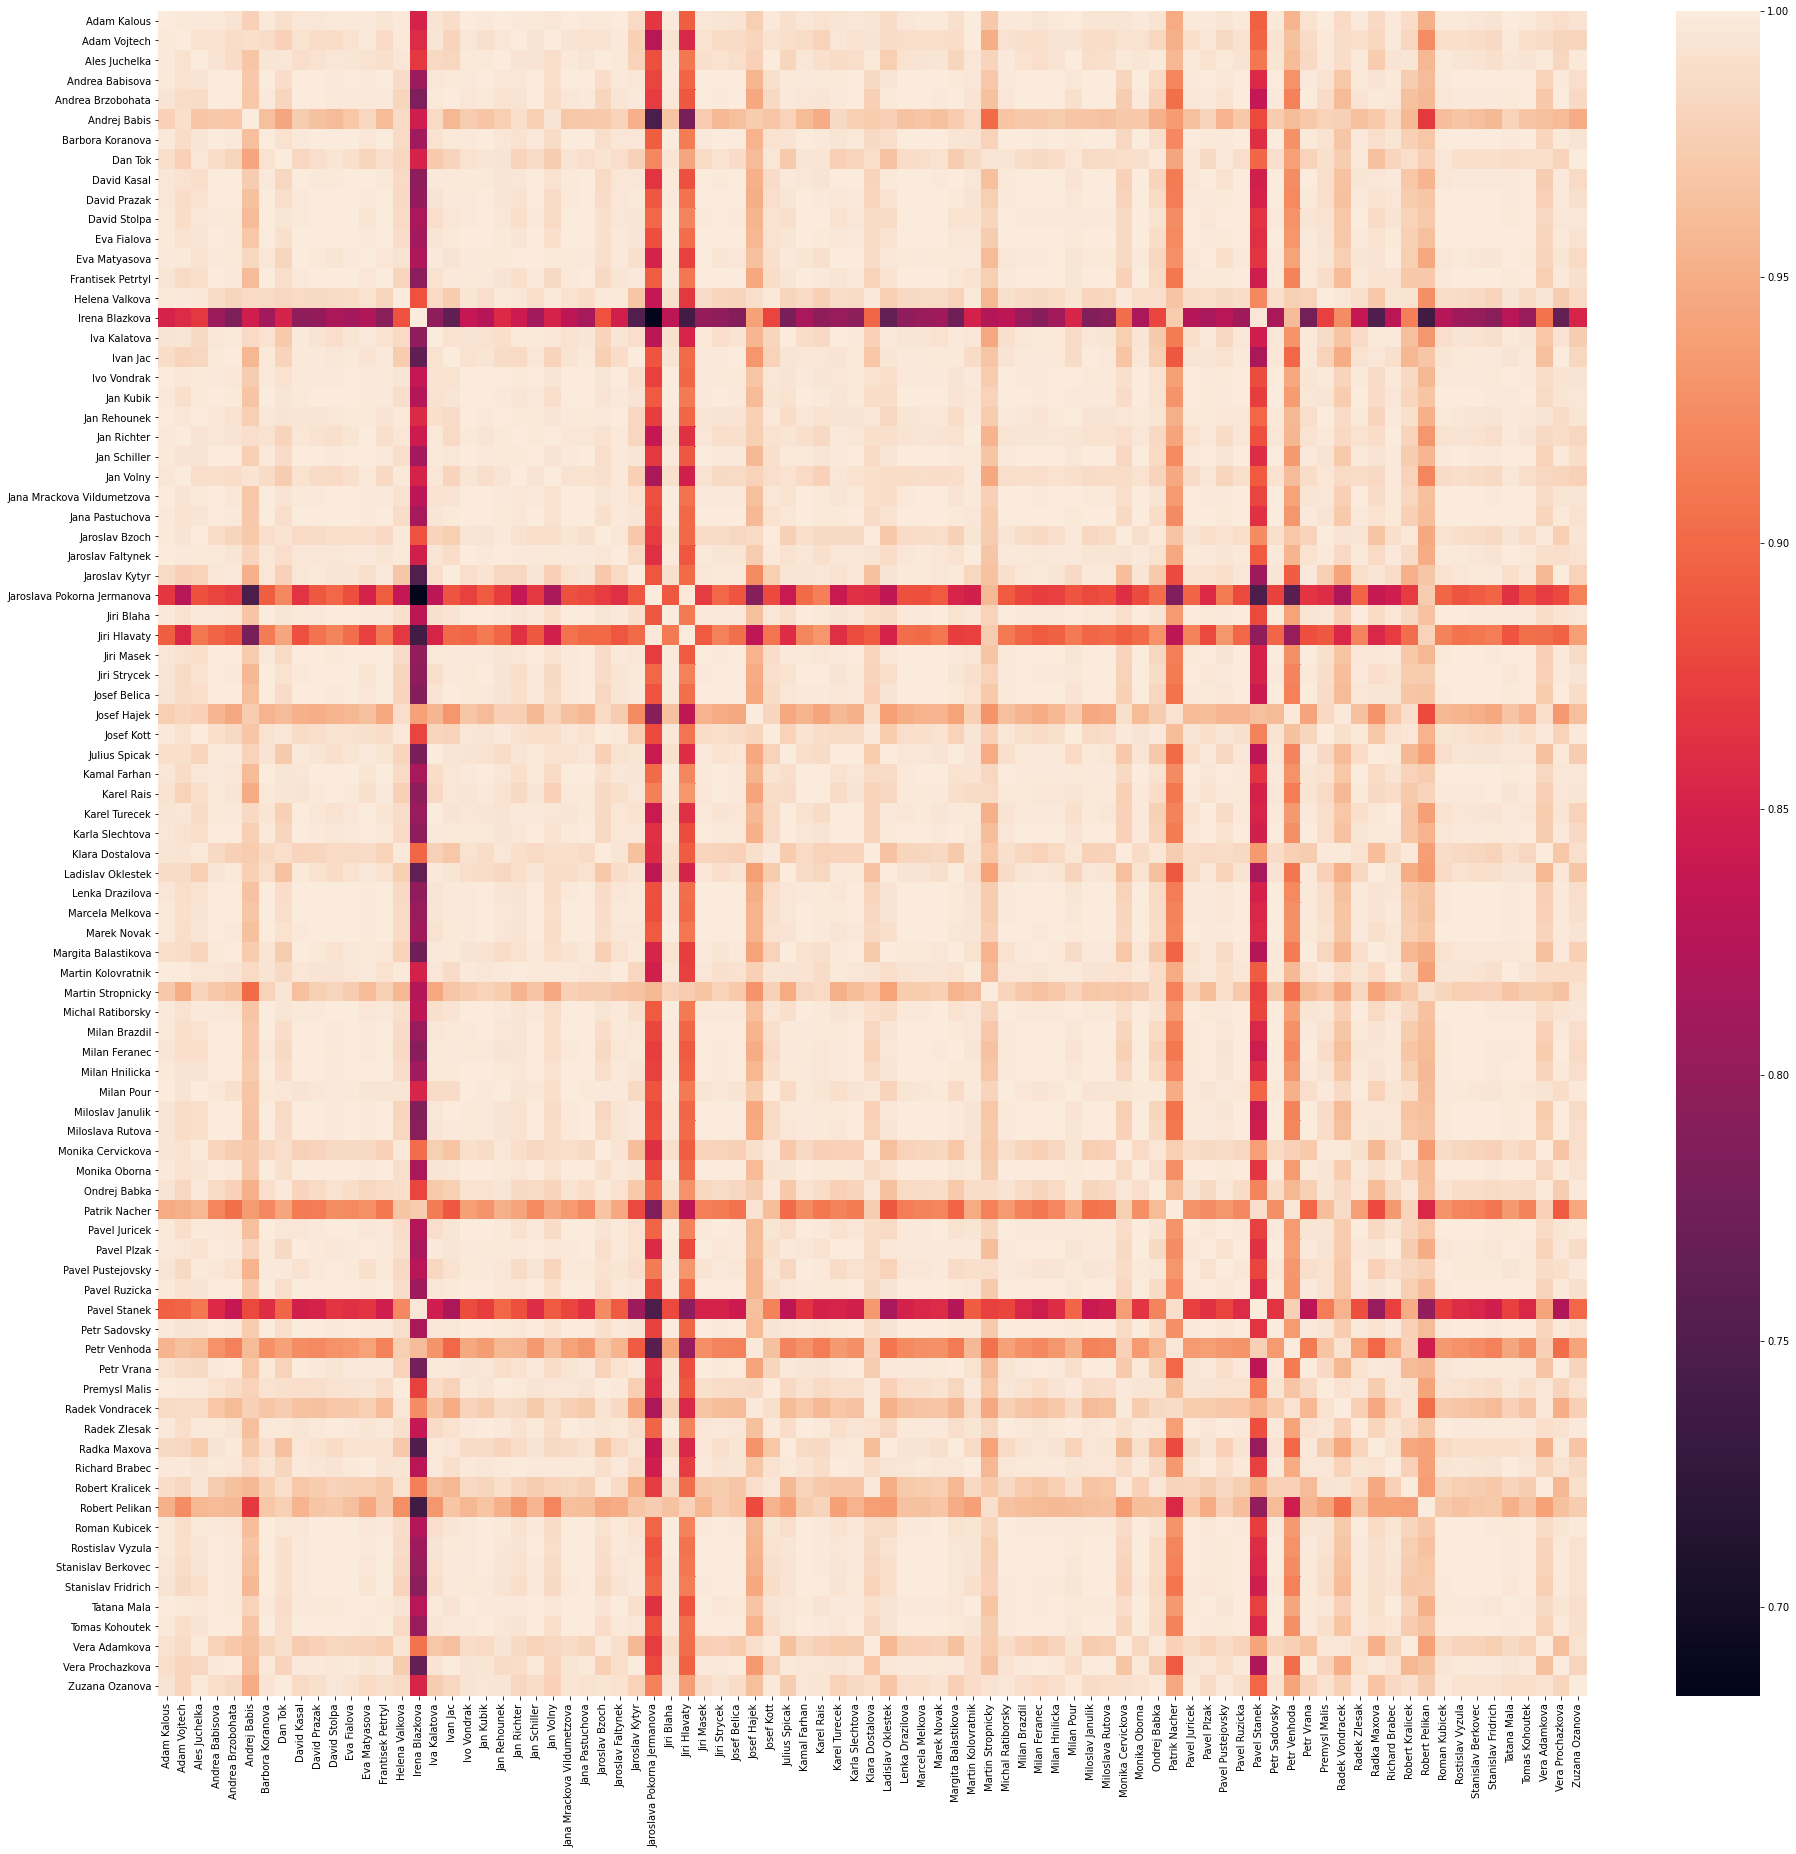

Nejvetsi rebelove strany CSSD jsou: Jan Hamacek, Bohuslav Sobotka, Vaclav Votava


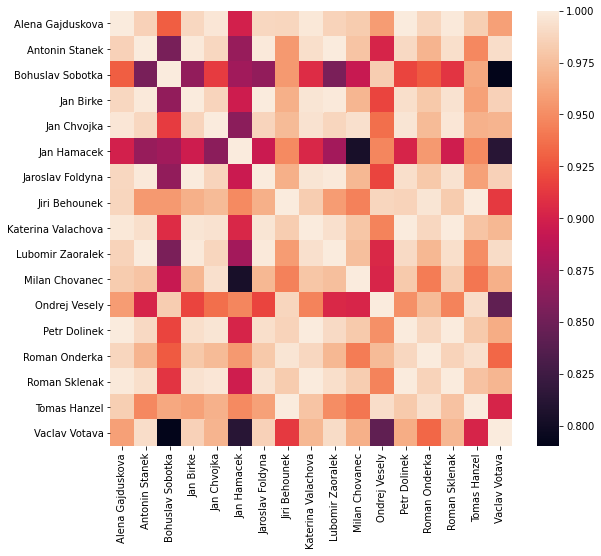

Nejvetsi rebelove strany KDU-CSL jsou: Stanislav Juranek, Pavel Belobradek, Ondrej Benesik


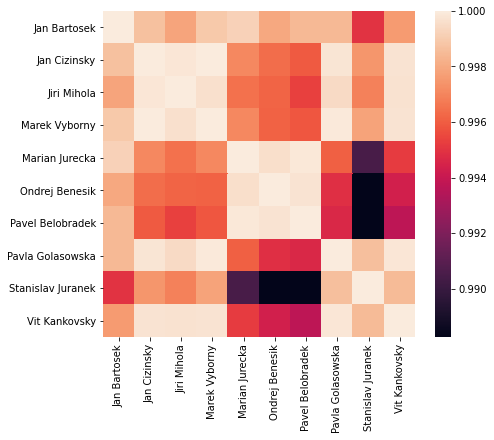

Nejvetsi rebelove strany KSCM jsou: Jiri Dolejs, Vladimir Konicek, Kveta Matusovska


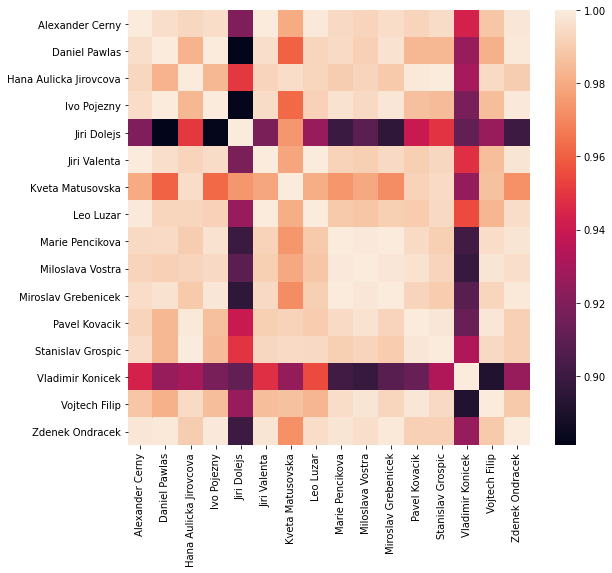

Nejvetsi rebelove strany Nezaraz jsou: Vaclav Klaus, Ivana Nevludova, Lubomir Volny


Nejvetsi rebelove strany ODS jsou: Vaclav Klaus, Pavel Blazek, Marek Benda


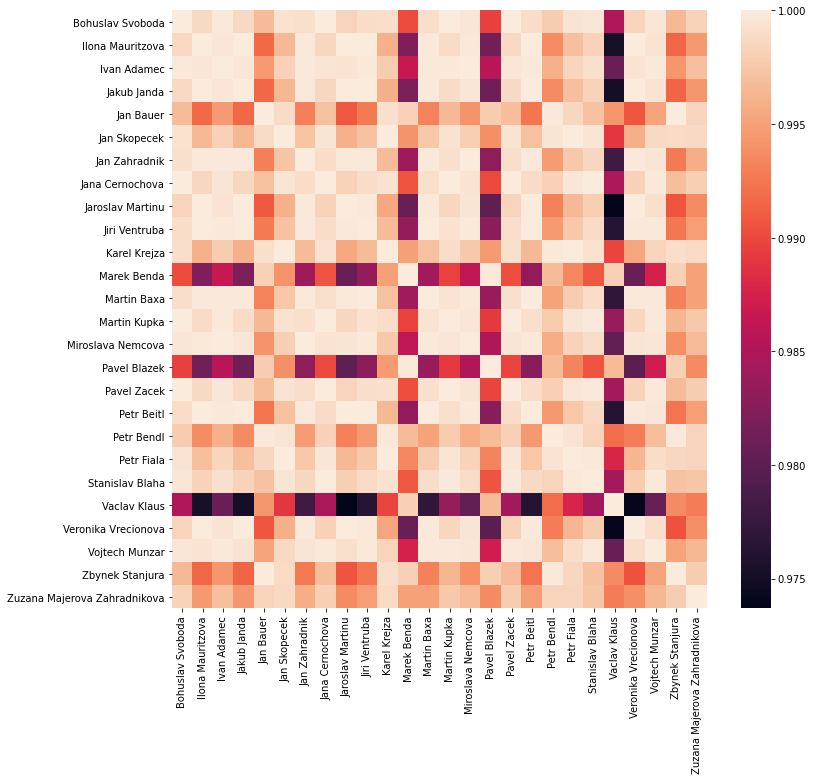

Nejvetsi rebelove strany Pirati jsou: Mikulas Peksa, Vojtech Pikal, Frantisek Kopriva


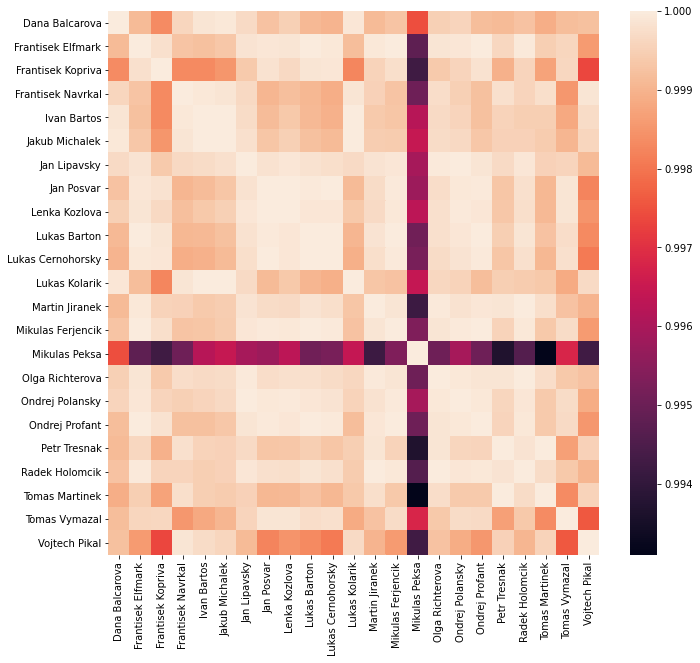

Nejvetsi rebelove strany SPD jsou: Jan Hrncir, Radim Fiala, Lubomir Spanel


Nejvetsi rebelove strany STAN jsou: Petr Pavek, Martin Puta, Jana Krutakova


Nejvetsi rebelove strany TOP09 jsou: Miroslav Kalousek, Karel Schwarzenberg, Dominik Feri


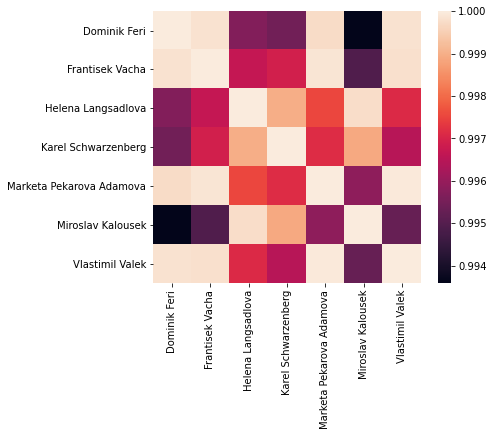

In [39]:
votes_names = votes.groupby(['Party', 'Name']).sum().drop(columns=['Sitting', 'Voting'])
votes_normalised = votes_names.div(votes_names.sum(axis=1), axis=0).dropna()

for party, df in votes_normalised.groupby('Party'):
    names = [n[1] for n in df.index]  # of deputies
    temp_df = pd.DataFrame(cosine_similarity(df), index=names, columns=names)
    rebels = list(temp_df.sum().nsmallest(3).index)
    print(f'Nejvetsi rebelove strany {party} jsou: {", ".join(rebels)}')
    fig = plt.figure(figsize=(int(len(names)/3) + 4, int(len(names)/3) + 3))
    sns.heatmap(data=temp_df)
    plt.show()

#### 5) Zkusime najit dulezita hlasovani. 
Treba rozpoctova hlasovani

In [61]:
sittings = sittings_df.dropna()
sittings.Name = sittings.Name.apply(lambda x: unidecode(x))  # problems with encoding
accepted_votings = sittings[(sittings.Name.str.contains('rozp')) & (sittings.Result == 'Prijato')]
accepted_votings_keys = list(accepted_votings.groupby(['Sitting', 'N_vote']).groups.keys())

In [72]:
reindexed_votes = votes_df.set_index(['Sitting', 'Voting'])
important_votes = reindexed_votes.loc[reindexed_votes.index.isin(accepted_votings_keys)]

In [73]:
dummies = pd.get_dummies(important_votes.Vote)
important_votes = pd.concat([important_votes.drop(columns='Vote'), dummies], axis=1)
important_votes

Name    Party  excused  no  \
Sitting Voting                                                       
3       5                      Vera Adamkova      ANO        0   0   
        5                       Andrej Babis      ANO        0   0   
        5                    Andrea Babisova      ANO        0   0   
        5                Margita Balastikova      ANO        0   0   
        5                       Josef Belica      ANO        0   0   
...                                      ...      ...      ...  ..   
58      299                   Tereza Hythova  Nezaraz        1   0   
        299                     Vaclav Klaus  Nezaraz        1   0   
        299     Zuzana Majerova Zahradnikova  Nezaraz        1   0   
        299                  Ivana Nevludova  Nezaraz        0   0   
        299                    Lubomir Volny  Nezaraz        1   0   

                not_registered  refrained  yes  
Sitting Voting                                  
3       5                    0          0    1  
        5                    0          0    1  
        5                    0          0    1  
        5                    0          0    1  
        5                    0          0    1  
...                        ...        ...  ...  
58      299                  0          0    0  
        299                  0          0    0  
        299                  0          0    0  
        299                  0          1    0  
        299                  0          0    0  

[23200 rows x 7 columns]

<AxesSubplot:xlabel='Party'>

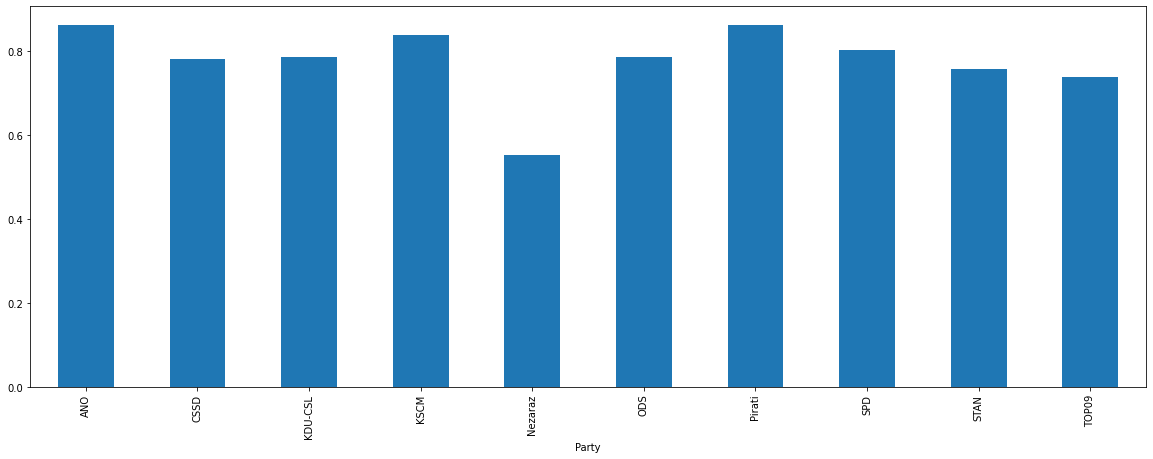

In [86]:
party_sum = important_votes.drop(columns='Name', inplace=False).groupby('Party').sum()
party_sum_norm = party_sum.div(party_sum.sum(axis=1), axis=0)

party_sum_norm['Attended'] = party_sum_norm.yes + party_sum_norm.no + party_sum_norm.refrained
party_sum_norm.plot.bar(y='Attended', legend=False, figsize=(20, 7))

In [90]:
party_sum_norm.Attended

Party
ANO        0.860411
CSSD       0.779282
KDU-CSL    0.784483
KSCM       0.836782
Nezaraz    0.552023
ODS        0.784966
Pirati     0.862461
SPD        0.802521
STAN       0.755747
TOP09      0.737685
Name: Attended, dtype: float64

Zajimave, ze na hlasovanich tykajicich se rozpoctu stredni dochazka je mensi nez celkova. Nejlepsi dochazku opet maji pirati.

<AxesSubplot:xlabel='Party'>

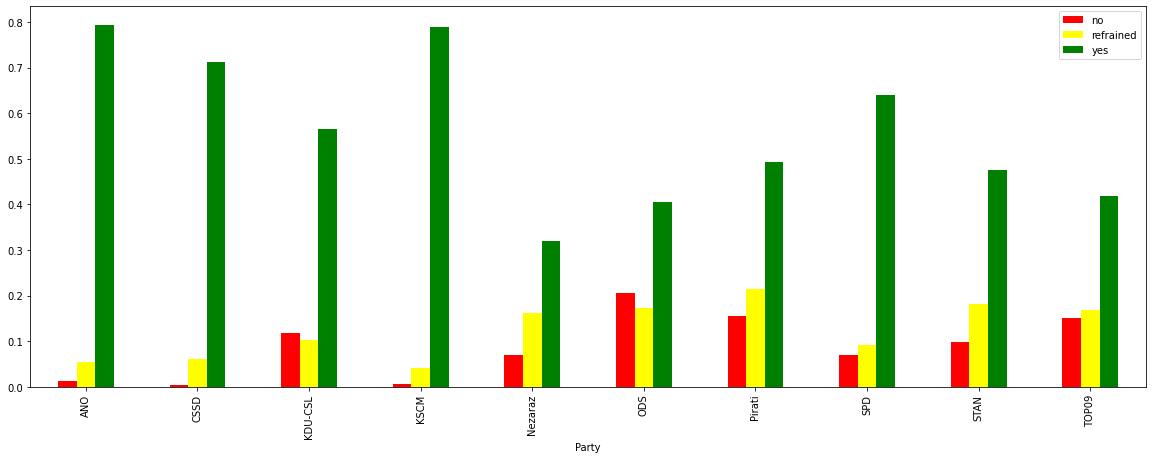

In [97]:
party_sum_norm_v = party_sum_norm.drop(columns=['excused', 'not_registered', 'Attended'])
party_sum_norm_v.plot.bar(figsize=(20, 7), color=['red', 'yellow', 'green'])

Vzpomenme si na sejny graf ze vsech hlasovani. Tady v dulezitych hlasovanich je videt velmi zajimava zalezitost. Strany ANO, CSSD a KSCM v hlasovanich tykajicich se rozpoctu jsou velmi jednoznacni, hlasujou ZA v drtive vetsine pripadu, ale ostatni strany casteji hlasujou proti nebo se zdrzujou. To je opak toho, co jsme videli na stejnem grafu shrujicim sechna hlasovani. 